# Studying the effects of the energy resolution

Miscellaneous:

In [1]:
import sys

sys.path.append("../../..")

import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib import rc
import mpl_toolkits.axes_grid1.inset_locator as inloc
import scipy.stats as stats
import src.energy_effects_t2k.convolution as conv
import src.nu_osc.osc_prob as osc
import src.nu_osc.default_parameters as param

<p> </p>
To make plots more beautiful

In [2]:
rc("figure", figsize=(10, 5))
# rc('lines', linewidth=2)
rc("axes", labelsize=12, linewidth=1, grid=True, labelpad=-1, axisbelow=True)
rc("axes.spines", right=True)
rc("xtick", direction="in", labelsize=12, top=True)
rc("xtick.major", width=0.8, size=5)
rc("ytick", direction="in", labelsize=12, right=True)
rc("ytick.major", width=0.8, size=5)
rc("legend", fancybox=False, fontsize=12, shadow=False)
rc(
    "grid",
    linewidth=1.0,
)  # ls='dotted')
# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [3]:
colors = {
    "numu": "darkgreen",
    "antinumu": "darkseagreen",
    "nue": "red",
    "antinue": "rosybrown",
    "nutau": "teal",
    "antinutau": "cadetblue",
}

## Plotting the best fit from NuFIT 2024

Importing the T2K FHC flux:

In [4]:
t2kflux_2020_plus250kA_nominal_sk = conv.fluximport(
    "t2kflux_2020_plus250kA_nominal_sk.csv"
)

Importing the neutrino CCQE interaction cross-section:

In [5]:
ccqe_interp = conv.xsecimport(
    name="neutrino_ccqe.csv",
    mode="true filter interp",
    keep_left=5,
    on=(t2kflux_2020_plus250kA_nominal_sk.minE + t2kflux_2020_plus250kA_nominal_sk.maxE)
    / 2,
)

Multiplying the flux, the cross-section and SK's sp to obtain the numbers per MeV at SK:

In [6]:
number = pd.DataFrame()
for key in ["minE", "maxE"]:
    number[key] = t2kflux_2020_plus250kA_nominal_sk[key]
for key in ["numu", "antinumu", "nue", "antinue"]:
    number[key] = (
        (ccqe_interp.xsec * t2kflux_2020_plus250kA_nominal_sk[key] / (50 * 1e21))
        * param.SK_POT
        * param.TOT_NEUTRONS
        * 2
    )

Oscillating the number with the best fit from NuFIT 24:

In [7]:
number["nutau"] = 0.0
number["antinutau"] = 0.0

In [8]:
number_oscillated = {
    "bf": conv.oscillate(to_oscillate=number),
    "p1sigma": conv.oscillate(
        to_oscillate=number, dm2_atm=param.NUFIT["Dm_square_32"]["p1sigma"]
    ),
    "m1sigma": conv.oscillate(
        to_oscillate=number, dm2_atm=param.NUFIT["Dm_square_32"]["m1sigma"]
    ),
    "p3sigma": conv.oscillate(
        to_oscillate=number, dm2_atm=param.NUFIT["Dm_square_32"]["p3sigma"]
    ),
    "m3sigma": conv.oscillate(
        to_oscillate=number, dm2_atm=param.NUFIT["Dm_square_32"]["m3sigma"]
    ),
}

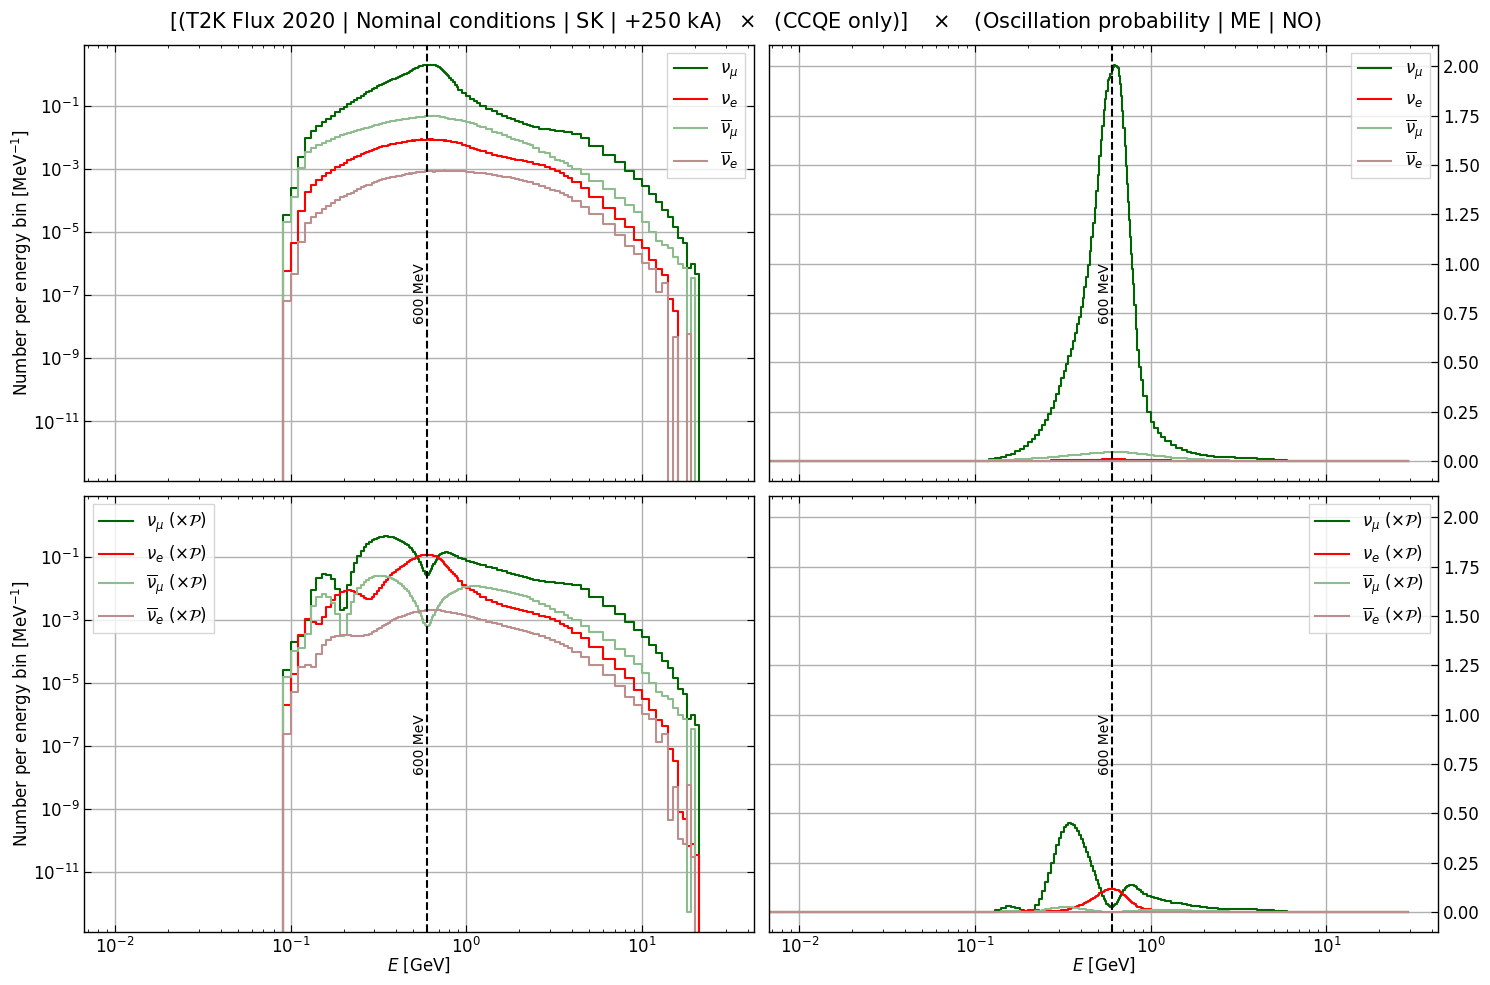

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex="col", sharey="col")

for i in [0, 1]:
    for key in [
        "numu",
        "nue",
        "antinumu",
        "antinue",
    ]:  # "nutau", "antinutau"]:
        axs[0, i].step(
            number.minE,
            number[key],
            label=conv.print_dict[key],
            color=colors[key],
            where="post",
        )

        axs[1, i].step(
            number_oscillated["bf"].minE,
            number_oscillated["bf"][key],
            label=conv.print_dict[key] + r" ($\times \mathcal{P}$)",
            color=colors[key],
            where="post",
        )

    axs[1, i].set_xlabel(r"$E$ [GeV]")

for ax in axs.reshape(-1):
    ax.set_xscale("log")
    ax.legend()
    ax.text(
        x=0.6,
        y=0.5,
        s=r"600 MeV",
        ha="right",
        va="top",
        rotation=90,
        transform=ax.get_xaxis_transform(),
    )
    ax.axvline(x=0.6, linestyle="--", color="black")

for i in range(2):
    axs[i, 0].set_yscale("log")
    # axs[i,0].set_ylim(bottom=1e-1)
    axs[i, 1].yaxis.tick_right()

axs[0, 0].set_ylabel(r"Number per energy bin [$\text{MeV}^{-1}$]")
axs[1, 0].set_ylabel(r"Number per energy bin [$\text{MeV}^{-1}$]")

fig.suptitle(
    r"[(T2K Flux 2020 | Nominal conditions | SK | $+250$ kA) $\ \times \ $ (CCQE only)] $\ \ \times \ \ $ (Oscillation probability | ME | NO)",
    fontsize=15,
)
fig.tight_layout()

plt.show()

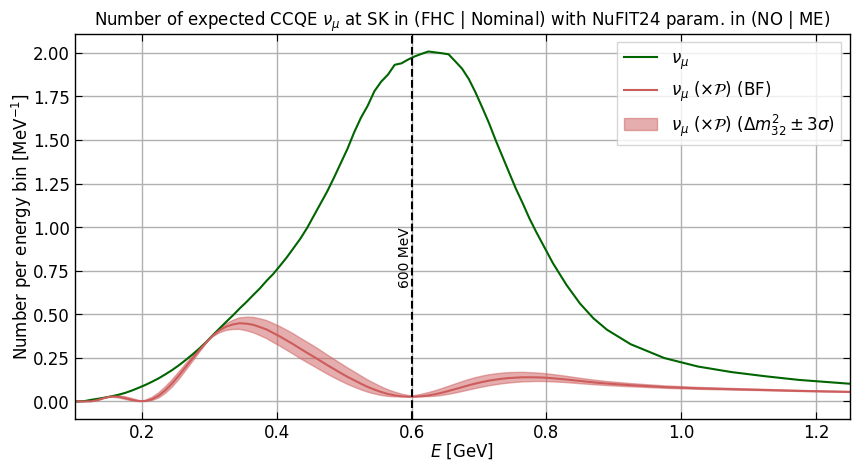

In [10]:
for key in ["numu"]:
    plt.plot(
        (number.minE + number.maxE) / 2,
        number[key],
        label=conv.print_dict[key],
        color=colors[key],
        # alpha=.5,
        # linestyle='--',
    )

    plt.plot(
        (number_oscillated["bf"].minE + number_oscillated["bf"].maxE) / 2,
        number_oscillated["bf"][key],
        label=conv.print_dict[key] + r" ($\times \mathcal{P}$) (BF)",
        color="indianred",
    )

    plt.fill_between(
        (number_oscillated["bf"].minE + number_oscillated["bf"].maxE) / 2,
        number_oscillated["m3sigma"][key],
        number_oscillated["p3sigma"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P})\ (\Delta m_{32}^2 \pm 3\sigma$)",
        color="indianred",
        alpha=0.5,
    )


plt.axvline(x=0.6, linestyle="--", color="black")
ax = plt.gca()
plt.text(
    x=0.6,
    y=0.5,
    s=r"600 MeV",
    ha="right",
    va="top",
    rotation=90,
    transform=ax.get_xaxis_transform(),
)

# plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"$E$ [GeV]")
plt.ylabel(r"Number per energy bin [$\text{MeV}^{-1}$]")
# plt.ylim(bottom=1e-1)
plt.xlim([0.1, 1.25])
plt.title(
    r"Number of expected CCQE $\nu_\mu$ at SK in (FHC | Nominal) with NuFIT24 param. in (NO | ME)"
)
plt.legend()

plt.show()

In [11]:
ccqe_energy_res_interp = conv.energyimport(
    name="ccqe_energy_res.csv", mode="interp", on=np.linspace(-0.5, 1.0, 125)
)

In [12]:
oscillated_smeared = {}
for key in number_oscillated:
    oscillated_smeared[key] = conv.convolve(
        input=number_oscillated[key], gate=ccqe_energy_res_interp
    )

In [13]:
params = {
    "dm2_atm": [
        param.NUFIT["Dm_square_32"]["m3sigma"],
        param.NUFIT["Dm_square_32"]["p3sigma"],
    ]
}

oscillate_min, oscillate_max = conv.envelope(to_oscillate=number, params=params)
smeared_min, smeared_max = conv.envelope(
    to_oscillate=number, params=params, gate=ccqe_energy_res_interp
)

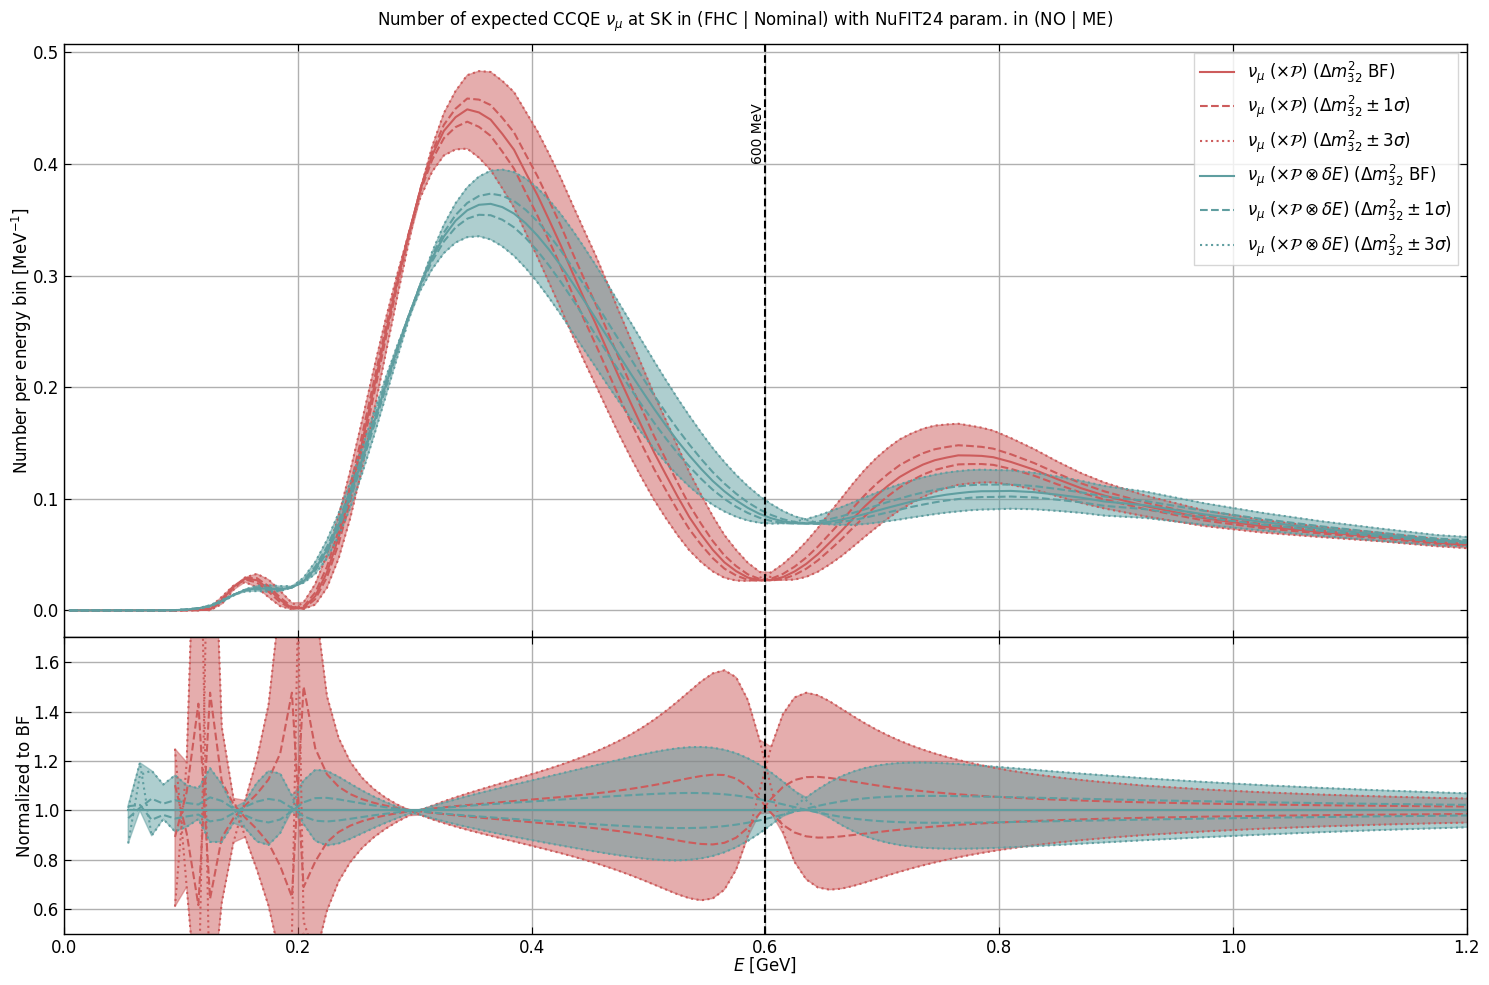

In [14]:
fig, axs = plt.subplots(
    2,
    1,
    sharex="col",
    sharey="row",
    figsize=(15, 10),
    gridspec_kw={"height_ratios": [2, 1]},
)
fig.subplots_adjust(wspace=0, hspace=0)

for key in ["numu"]:
    axs[0].plot(
        (number_oscillated["bf"].minE + number_oscillated["bf"].maxE) / 2,
        number_oscillated["bf"][key],
        label=conv.print_dict[key] + r" ($\times \mathcal{P}$) ($\Delta m_{32}^2$ BF)",
        color="indianred",
    )

    axs[0].plot(
        (number_oscillated["p1sigma"].minE + number_oscillated["p1sigma"].maxE) / 2,
        number_oscillated["p1sigma"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P}$) ($\Delta m_{32}^2 \pm 1\sigma$)",
        color="indianred",
        linestyle="--",
    )

    axs[0].plot(
        (number_oscillated["m1sigma"].minE + number_oscillated["m1sigma"].maxE) / 2,
        number_oscillated["m1sigma"][key],
        color="indianred",
        linestyle="--",
    )

    axs[0].plot(
        (number_oscillated["p3sigma"].minE + number_oscillated["p3sigma"].maxE) / 2,
        number_oscillated["p3sigma"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P}$) ($\Delta m_{32}^2 \pm 3\sigma$)",
        color="indianred",
        linestyle="dotted",
    )

    axs[0].plot(
        (number_oscillated["m3sigma"].minE + number_oscillated["m3sigma"].maxE) / 2,
        number_oscillated["m3sigma"][key],
        color="indianred",
        linestyle="dotted",
    )

    axs[0].fill_between(
        (oscillate_max.minE + oscillate_min.maxE) / 2,
        oscillate_max[key],
        oscillate_min[key],
        # label=conv.print_dict[key] + r" ($\times \mathcal{P})\ (\Delta m_{32}^2 \pm 3\sigma$)",
        color="indianred",
        alpha=0.5,
    )

    axs[0].plot(
        (oscillated_smeared["bf"].minE + oscillated_smeared["bf"].maxE) / 2,
        oscillated_smeared["bf"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P} \otimes \delta E$) ($\Delta m_{32}^2$ BF)",
        color="cadetblue",
    )

    axs[0].plot(
        (oscillated_smeared["p1sigma"].minE + oscillated_smeared["p1sigma"].maxE) / 2,
        oscillated_smeared["p1sigma"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P} \otimes \delta E$) ($\Delta m_{32}^2 \pm 1\sigma$)",
        color="cadetblue",
        linestyle="--",
    )

    axs[0].plot(
        (oscillated_smeared["m1sigma"].minE + oscillated_smeared["m1sigma"].maxE) / 2,
        oscillated_smeared["m1sigma"][key],
        color="cadetblue",
        linestyle="--",
    )

    axs[0].plot(
        (oscillated_smeared["p3sigma"].minE + oscillated_smeared["p3sigma"].maxE) / 2,
        oscillated_smeared["p3sigma"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P} \otimes \delta E$) ($\Delta m_{32}^2 \pm 3\sigma$)",
        color="cadetblue",
        linestyle="dotted",
    )

    axs[0].plot(
        (oscillated_smeared["m3sigma"].minE + oscillated_smeared["m3sigma"].maxE) / 2,
        oscillated_smeared["m3sigma"][key],
        color="cadetblue",
        linestyle="dotted",
    )

    axs[0].fill_between(
        (smeared_max.minE + smeared_min.maxE) / 2,
        smeared_max[key],
        smeared_min[key],
        # label=conv.print_dict[key] + r" ($\times \mathcal{P})\ (\Delta m_{32}^2 \pm 3\sigma$)",
        color="cadetblue",
        alpha=0.5,
    )

    axs[1].plot(
        (number_oscillated["bf"].minE + number_oscillated["bf"].maxE) / 2,
        number_oscillated["bf"][key] / number_oscillated["bf"][key],
        color="indianred",
    )

    axs[1].plot(
        (number_oscillated["p1sigma"].minE + number_oscillated["p1sigma"].maxE) / 2,
        number_oscillated["p1sigma"][key] / number_oscillated["bf"][key],
        color="indianred",
        linestyle="--",
    )

    axs[1].plot(
        (number_oscillated["m1sigma"].minE + number_oscillated["m1sigma"].maxE) / 2,
        number_oscillated["m1sigma"][key] / number_oscillated["bf"][key],
        color="indianred",
        linestyle="--",
    )

    axs[1].plot(
        (number_oscillated["p3sigma"].minE + number_oscillated["p3sigma"].maxE) / 2,
        number_oscillated["p3sigma"][key] / number_oscillated["bf"][key],
        color="indianred",
        linestyle="dotted",
    )

    axs[1].plot(
        (number_oscillated["m3sigma"].minE + number_oscillated["m3sigma"].maxE) / 2,
        number_oscillated["m3sigma"][key] / number_oscillated["bf"][key],
        color="indianred",
        linestyle="dotted",
    )

    axs[1].fill_between(
        (oscillate_max.minE + oscillate_min.maxE) / 2,
        oscillate_max[key] / number_oscillated["bf"][key],
        oscillate_min[key] / number_oscillated["bf"][key],
        color="indianred",
        alpha=0.5,
    )

    axs[1].plot(
        (oscillated_smeared["bf"].minE + oscillated_smeared["bf"].maxE) / 2,
        oscillated_smeared["bf"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
    )

    axs[1].plot(
        (oscillated_smeared["p1sigma"].minE + oscillated_smeared["p1sigma"].maxE) / 2,
        oscillated_smeared["p1sigma"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        linestyle="--",
    )

    axs[1].plot(
        (oscillated_smeared["m1sigma"].minE + oscillated_smeared["m1sigma"].maxE) / 2,
        oscillated_smeared["m1sigma"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        linestyle="--",
    )

    axs[1].plot(
        (oscillated_smeared["p3sigma"].minE + oscillated_smeared["p3sigma"].maxE) / 2,
        oscillated_smeared["p3sigma"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        linestyle="dotted",
    )

    axs[1].plot(
        (oscillated_smeared["m3sigma"].minE + oscillated_smeared["m3sigma"].maxE) / 2,
        oscillated_smeared["m3sigma"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        linestyle="dotted",
    )

    axs[1].fill_between(
        (smeared_max.minE + smeared_min.maxE) / 2,
        smeared_max[key] / oscillated_smeared["bf"][key],
        smeared_min[key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        alpha=0.5,
    )

for ax in axs:
    ax.axvline(x=0.6, linestyle="--", color="black")
axs[0].text(
    x=0.6,
    y=0.9,
    s=r"600 MeV",
    ha="right",
    va="top",
    rotation=90,
    transform=axs[0].get_xaxis_transform(),
)

# plt.xscale("log")
# plt.yscale("log")
axs[1].set_xlabel(r"$E$ [GeV]")
axs[0].set_ylabel(r"Number per energy bin [$\text{MeV}^{-1}$]")
axs[1].set_ylabel(r"Normalized to BF")
# plt.ylim(bottom=1e-1)
axs[0].set_xlim([0.0, 1.2])
axs[1].set_ylim([0.5, 1.7])
# plt.ylim([0.02,0.1])
plt.suptitle(
    r"Number of expected CCQE $\nu_\mu$ at SK in (FHC | Nominal) with NuFIT24 param. in (NO | ME)"
)
axs[0].legend()


plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [16]:
number_oscillated = {
    "bf": conv.oscillate(to_oscillate=number),
    "p1sigma": conv.oscillate(
        to_oscillate=number, delta_cp=param.NUFIT["delta_CP"]["p1sigma"]
    ),
    "m1sigma": conv.oscillate(
        to_oscillate=number, delta_cp=param.NUFIT["delta_CP"]["m1sigma"]
    ),
    "p3sigma": conv.oscillate(
        to_oscillate=number, delta_cp=param.NUFIT["delta_CP"]["p3sigma"]
    ),
    "m3sigma": conv.oscillate(
        to_oscillate=number, delta_cp=param.NUFIT["delta_CP"]["m3sigma"]
    ),
}

oscillated_smeared = {}
for key in number_oscillated:
    oscillated_smeared[key] = conv.convolve(
        input=number_oscillated[key], gate=ccqe_energy_res_interp
    )

params = {
    "delta_cp": [param.NUFIT["delta_CP"]["m3sigma"], param.NUFIT["delta_CP"]["p3sigma"]]
}

oscillate_min, oscillate_max = conv.envelope(to_oscillate=number, params=params)
smeared_min, smeared_max = conv.envelope(
    to_oscillate=number, params=params, gate=ccqe_energy_res_interp
)

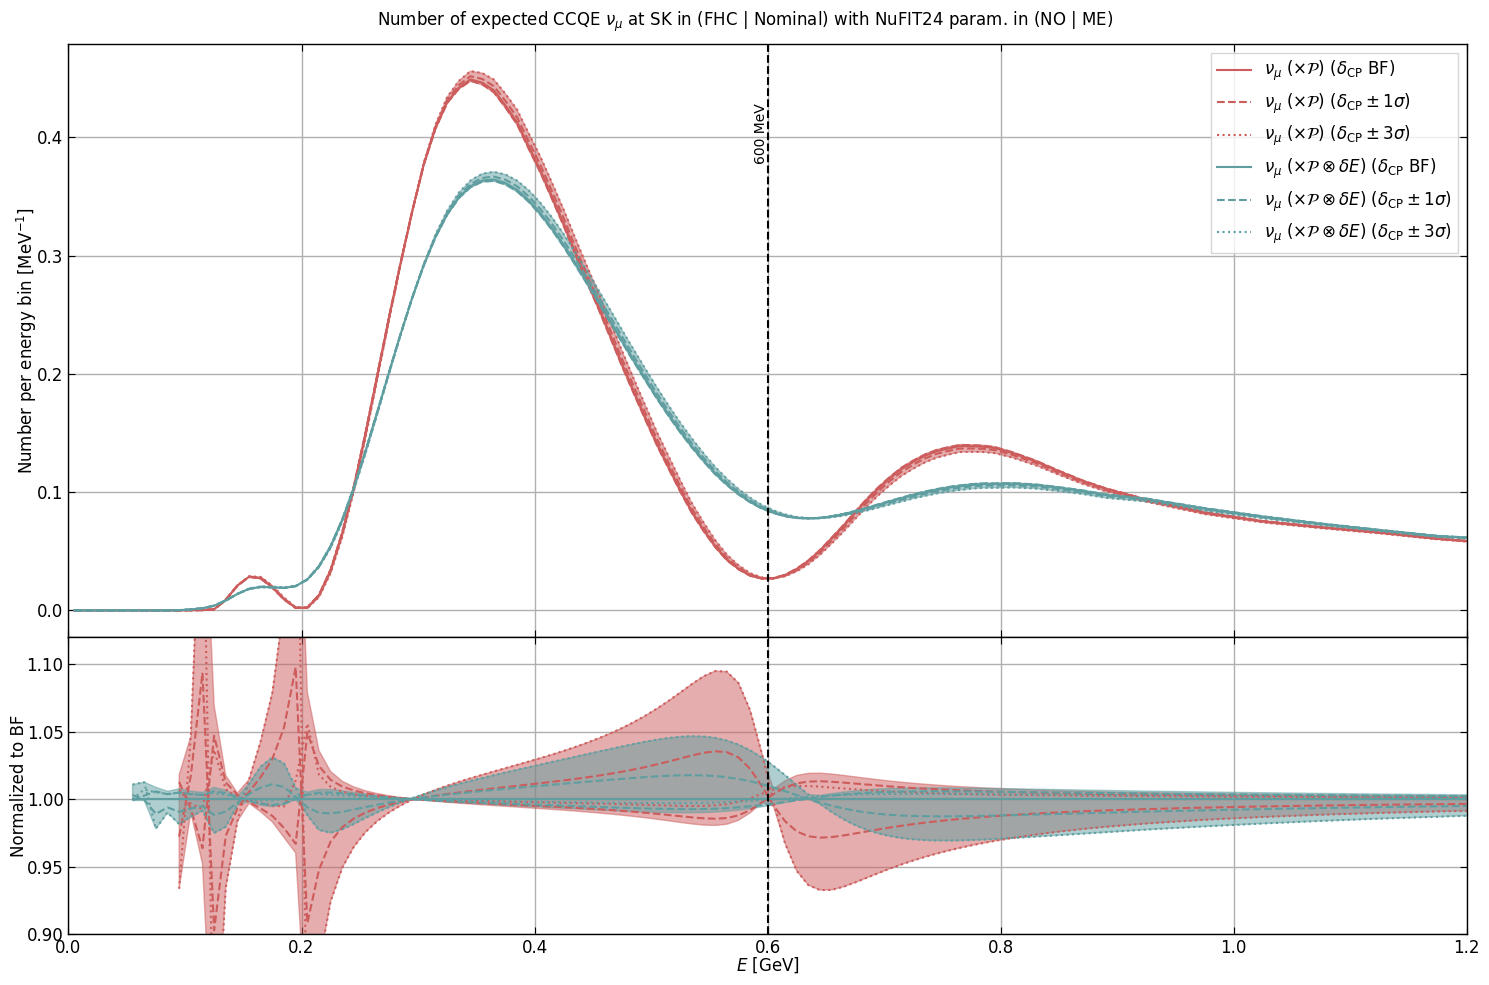

In [19]:
fig, axs = plt.subplots(
    2,
    1,
    sharex="col",
    sharey="row",
    figsize=(15, 10),
    gridspec_kw={"height_ratios": [2, 1]},
)
fig.subplots_adjust(wspace=0, hspace=0)

for key in ["numu"]:
    axs[0].plot(
        (number_oscillated["bf"].minE + number_oscillated["bf"].maxE) / 2,
        number_oscillated["bf"][key],
        label=conv.print_dict[key] + r" ($\times \mathcal{P}$) ($\delta_\text{CP}$ BF)",
        color="indianred",
    )

    axs[0].plot(
        (number_oscillated["p1sigma"].minE + number_oscillated["p1sigma"].maxE) / 2,
        number_oscillated["p1sigma"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P}$) ($\delta_\text{CP} \pm 1\sigma$)",
        color="indianred",
        linestyle="--",
    )

    axs[0].plot(
        (number_oscillated["m1sigma"].minE + number_oscillated["m1sigma"].maxE) / 2,
        number_oscillated["m1sigma"][key],
        color="indianred",
        linestyle="--",
    )

    axs[0].plot(
        (number_oscillated["p3sigma"].minE + number_oscillated["p3sigma"].maxE) / 2,
        number_oscillated["p3sigma"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P}$) ($\delta_\text{CP} \pm 3\sigma$)",
        color="indianred",
        linestyle="dotted",
    )

    axs[0].plot(
        (number_oscillated["m3sigma"].minE + number_oscillated["m3sigma"].maxE) / 2,
        number_oscillated["m3sigma"][key],
        color="indianred",
        linestyle="dotted",
    )

    axs[0].fill_between(
        (oscillate_max.minE + oscillate_min.maxE) / 2,
        oscillate_max[key],
        oscillate_min[key],
        # label=conv.print_dict[key] + r" ($\times \mathcal{P})\ (\Delta m_{32}^2 \pm 3\sigma$)",
        color="indianred",
        alpha=0.5,
    )

    axs[0].plot(
        (oscillated_smeared["bf"].minE + oscillated_smeared["bf"].maxE) / 2,
        oscillated_smeared["bf"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P} \otimes \delta E$) ($\delta_\text{CP}$ BF)",
        color="cadetblue",
    )

    axs[0].plot(
        (oscillated_smeared["p1sigma"].minE + oscillated_smeared["p1sigma"].maxE) / 2,
        oscillated_smeared["p1sigma"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P} \otimes \delta E$) ($\delta_\text{CP} \pm 1\sigma$)",
        color="cadetblue",
        linestyle="--",
    )

    axs[0].plot(
        (oscillated_smeared["m1sigma"].minE + oscillated_smeared["m1sigma"].maxE) / 2,
        oscillated_smeared["m1sigma"][key],
        color="cadetblue",
        linestyle="--",
    )

    axs[0].plot(
        (oscillated_smeared["p3sigma"].minE + oscillated_smeared["p3sigma"].maxE) / 2,
        oscillated_smeared["p3sigma"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P} \otimes \delta E$) ($\delta_\text{CP} \pm 3\sigma$)",
        color="cadetblue",
        linestyle="dotted",
    )

    axs[0].plot(
        (oscillated_smeared["m3sigma"].minE + oscillated_smeared["m3sigma"].maxE) / 2,
        oscillated_smeared["m3sigma"][key],
        color="cadetblue",
        linestyle="dotted",
    )

    axs[0].fill_between(
        (smeared_max.minE + smeared_min.maxE) / 2,
        smeared_max[key],
        smeared_min[key],
        # label=conv.print_dict[key] + r" ($\times \mathcal{P})\ (\Delta m_{32}^2 \pm 3\sigma$)",
        color="cadetblue",
        alpha=0.5,
    )

    axs[1].plot(
        (number_oscillated["bf"].minE + number_oscillated["bf"].maxE) / 2,
        number_oscillated["bf"][key] / number_oscillated["bf"][key],
        color="indianred",
    )

    axs[1].plot(
        (number_oscillated["p1sigma"].minE + number_oscillated["p1sigma"].maxE) / 2,
        number_oscillated["p1sigma"][key] / number_oscillated["bf"][key],
        color="indianred",
        linestyle="--",
    )

    axs[1].plot(
        (number_oscillated["m1sigma"].minE + number_oscillated["m1sigma"].maxE) / 2,
        number_oscillated["m1sigma"][key] / number_oscillated["bf"][key],
        color="indianred",
        linestyle="--",
    )

    axs[1].plot(
        (number_oscillated["p3sigma"].minE + number_oscillated["p3sigma"].maxE) / 2,
        number_oscillated["p3sigma"][key] / number_oscillated["bf"][key],
        color="indianred",
        linestyle="dotted",
    )

    axs[1].plot(
        (number_oscillated["m3sigma"].minE + number_oscillated["m3sigma"].maxE) / 2,
        number_oscillated["m3sigma"][key] / number_oscillated["bf"][key],
        color="indianred",
        linestyle="dotted",
    )

    axs[1].fill_between(
        (oscillate_max.minE + oscillate_min.maxE) / 2,
        oscillate_max[key] / number_oscillated["bf"][key],
        oscillate_min[key] / number_oscillated["bf"][key],
        color="indianred",
        alpha=0.5,
    )

    axs[1].plot(
        (oscillated_smeared["bf"].minE + oscillated_smeared["bf"].maxE) / 2,
        oscillated_smeared["bf"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
    )

    axs[1].plot(
        (oscillated_smeared["p1sigma"].minE + oscillated_smeared["p1sigma"].maxE) / 2,
        oscillated_smeared["p1sigma"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        linestyle="--",
    )

    axs[1].plot(
        (oscillated_smeared["m1sigma"].minE + oscillated_smeared["m1sigma"].maxE) / 2,
        oscillated_smeared["m1sigma"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        linestyle="--",
    )

    axs[1].plot(
        (oscillated_smeared["p3sigma"].minE + oscillated_smeared["p3sigma"].maxE) / 2,
        oscillated_smeared["p3sigma"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        linestyle="dotted",
    )

    axs[1].plot(
        (oscillated_smeared["m3sigma"].minE + oscillated_smeared["m3sigma"].maxE) / 2,
        oscillated_smeared["m3sigma"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        linestyle="dotted",
    )

    axs[1].fill_between(
        (smeared_max.minE + smeared_min.maxE) / 2,
        smeared_max[key] / oscillated_smeared["bf"][key],
        smeared_min[key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        alpha=0.5,
    )

for ax in axs:
    ax.axvline(x=0.6, linestyle="--", color="black")
axs[0].text(
    x=0.6,
    y=0.9,
    s=r"600 MeV",
    ha="right",
    va="top",
    rotation=90,
    transform=axs[0].get_xaxis_transform(),
)

# plt.xscale("log")
# plt.yscale("log")
axs[1].set_xlabel(r"$E$ [GeV]")
axs[0].set_ylabel(r"Number per energy bin [$\text{MeV}^{-1}$]")
axs[1].set_ylabel(r"Normalized to BF")
# plt.ylim(bottom=1e-1)
axs[0].set_xlim([0.0, 1.2])
axs[1].set_ylim([0.9, 1.12])
# plt.ylim([0.02,0.1])
plt.suptitle(
    r"Number of expected CCQE $\nu_\mu$ at SK in (FHC | Nominal) with NuFIT24 param. in (NO | ME)"
)
axs[0].legend()


plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [20]:
number_oscillated = {
    "bf": conv.oscillate(to_oscillate=number),
    "p1sigma": conv.oscillate(
        to_oscillate=number, theta_23=param.NUFIT["theta_23"]["p1sigma"]
    ),
    "m1sigma": conv.oscillate(
        to_oscillate=number, theta_23=param.NUFIT["theta_23"]["m1sigma"]
    ),
    "p3sigma": conv.oscillate(
        to_oscillate=number, theta_23=param.NUFIT["theta_23"]["p3sigma"]
    ),
    "m3sigma": conv.oscillate(
        to_oscillate=number, theta_23=param.NUFIT["theta_23"]["m3sigma"]
    ),
}

oscillated_smeared = {}
for key in number_oscillated:
    oscillated_smeared[key] = conv.convolve(
        input=number_oscillated[key], gate=ccqe_energy_res_interp
    )

params = {
    "theta_23": [param.NUFIT["theta_23"]["m3sigma"], param.NUFIT["theta_23"]["p3sigma"]]
}

oscillate_min, oscillate_max = conv.envelope(to_oscillate=number, params=params)
smeared_min, smeared_max = conv.envelope(
    to_oscillate=number, params=params, gate=ccqe_energy_res_interp
)

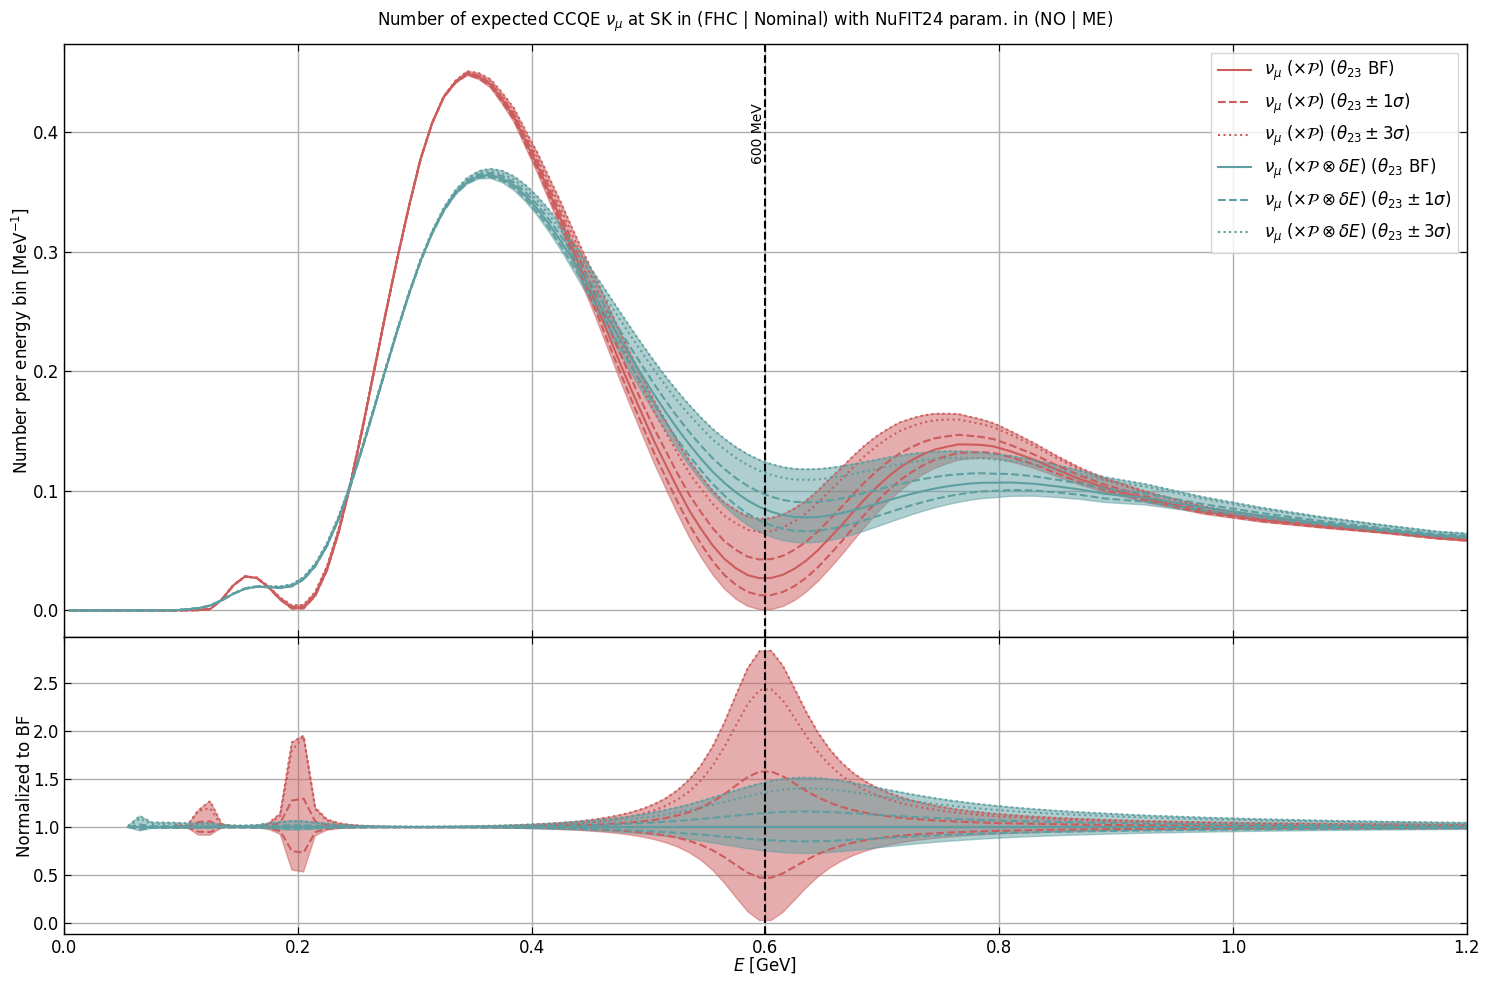

In [22]:
fig, axs = plt.subplots(
    2,
    1,
    sharex="col",
    sharey="row",
    figsize=(15, 10),
    gridspec_kw={"height_ratios": [2, 1]},
)
fig.subplots_adjust(wspace=0, hspace=0)

for key in ["numu"]:
    axs[0].plot(
        (number_oscillated["bf"].minE + number_oscillated["bf"].maxE) / 2,
        number_oscillated["bf"][key],
        label=conv.print_dict[key] + r" ($\times \mathcal{P}$) ($\theta_{23}$ BF)",
        color="indianred",
    )

    axs[0].plot(
        (number_oscillated["p1sigma"].minE + number_oscillated["p1sigma"].maxE) / 2,
        number_oscillated["p1sigma"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P}$) ($\theta_{23} \pm 1\sigma$)",
        color="indianred",
        linestyle="--",
    )

    axs[0].plot(
        (number_oscillated["m1sigma"].minE + number_oscillated["m1sigma"].maxE) / 2,
        number_oscillated["m1sigma"][key],
        color="indianred",
        linestyle="--",
    )

    axs[0].plot(
        (number_oscillated["p3sigma"].minE + number_oscillated["p3sigma"].maxE) / 2,
        number_oscillated["p3sigma"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P}$) ($\theta_{23} \pm 3\sigma$)",
        color="indianred",
        linestyle="dotted",
    )

    axs[0].plot(
        (number_oscillated["m3sigma"].minE + number_oscillated["m3sigma"].maxE) / 2,
        number_oscillated["m3sigma"][key],
        color="indianred",
        linestyle="dotted",
    )

    axs[0].fill_between(
        (oscillate_max.minE + oscillate_min.maxE) / 2,
        oscillate_max[key],
        oscillate_min[key],
        # label=conv.print_dict[key] + r" ($\times \mathcal{P})\ (\Delta m_{32}^2 \pm 3\sigma$)",
        color="indianred",
        alpha=0.5,
    )

    axs[0].plot(
        (oscillated_smeared["bf"].minE + oscillated_smeared["bf"].maxE) / 2,
        oscillated_smeared["bf"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P} \otimes \delta E$) ($\theta_{23}$ BF)",
        color="cadetblue",
    )

    axs[0].plot(
        (oscillated_smeared["p1sigma"].minE + oscillated_smeared["p1sigma"].maxE) / 2,
        oscillated_smeared["p1sigma"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P} \otimes \delta E$) ($\theta_{23} \pm 1\sigma$)",
        color="cadetblue",
        linestyle="--",
    )

    axs[0].plot(
        (oscillated_smeared["m1sigma"].minE + oscillated_smeared["m1sigma"].maxE) / 2,
        oscillated_smeared["m1sigma"][key],
        color="cadetblue",
        linestyle="--",
    )

    axs[0].plot(
        (oscillated_smeared["p3sigma"].minE + oscillated_smeared["p3sigma"].maxE) / 2,
        oscillated_smeared["p3sigma"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P} \otimes \delta E$) ($\theta_{23} \pm 3\sigma$)",
        color="cadetblue",
        linestyle="dotted",
    )

    axs[0].plot(
        (oscillated_smeared["m3sigma"].minE + oscillated_smeared["m3sigma"].maxE) / 2,
        oscillated_smeared["m3sigma"][key],
        color="cadetblue",
        linestyle="dotted",
    )

    axs[0].fill_between(
        (smeared_max.minE + smeared_min.maxE) / 2,
        smeared_max[key],
        smeared_min[key],
        # label=conv.print_dict[key] + r" ($\times \mathcal{P})\ (\Delta m_{32}^2 \pm 3\sigma$)",
        color="cadetblue",
        alpha=0.5,
    )

    axs[1].plot(
        (number_oscillated["bf"].minE + number_oscillated["bf"].maxE) / 2,
        number_oscillated["bf"][key] / number_oscillated["bf"][key],
        color="indianred",
    )

    axs[1].plot(
        (number_oscillated["p1sigma"].minE + number_oscillated["p1sigma"].maxE) / 2,
        number_oscillated["p1sigma"][key] / number_oscillated["bf"][key],
        color="indianred",
        linestyle="--",
    )

    axs[1].plot(
        (number_oscillated["m1sigma"].minE + number_oscillated["m1sigma"].maxE) / 2,
        number_oscillated["m1sigma"][key] / number_oscillated["bf"][key],
        color="indianred",
        linestyle="--",
    )

    axs[1].plot(
        (number_oscillated["p3sigma"].minE + number_oscillated["p3sigma"].maxE) / 2,
        number_oscillated["p3sigma"][key] / number_oscillated["bf"][key],
        color="indianred",
        linestyle="dotted",
    )

    axs[1].plot(
        (number_oscillated["m3sigma"].minE + number_oscillated["m3sigma"].maxE) / 2,
        number_oscillated["m3sigma"][key] / number_oscillated["bf"][key],
        color="indianred",
        linestyle="dotted",
    )

    axs[1].fill_between(
        (oscillate_max.minE + oscillate_min.maxE) / 2,
        oscillate_max[key] / number_oscillated["bf"][key],
        oscillate_min[key] / number_oscillated["bf"][key],
        color="indianred",
        alpha=0.5,
    )

    axs[1].plot(
        (oscillated_smeared["bf"].minE + oscillated_smeared["bf"].maxE) / 2,
        oscillated_smeared["bf"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
    )

    axs[1].plot(
        (oscillated_smeared["p1sigma"].minE + oscillated_smeared["p1sigma"].maxE) / 2,
        oscillated_smeared["p1sigma"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        linestyle="--",
    )

    axs[1].plot(
        (oscillated_smeared["m1sigma"].minE + oscillated_smeared["m1sigma"].maxE) / 2,
        oscillated_smeared["m1sigma"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        linestyle="--",
    )

    axs[1].plot(
        (oscillated_smeared["p3sigma"].minE + oscillated_smeared["p3sigma"].maxE) / 2,
        oscillated_smeared["p3sigma"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        linestyle="dotted",
    )

    axs[1].plot(
        (oscillated_smeared["m3sigma"].minE + oscillated_smeared["m3sigma"].maxE) / 2,
        oscillated_smeared["m3sigma"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        linestyle="dotted",
    )

    axs[1].fill_between(
        (smeared_max.minE + smeared_min.maxE) / 2,
        smeared_max[key] / oscillated_smeared["bf"][key],
        smeared_min[key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        alpha=0.5,
    )

for ax in axs:
    ax.axvline(x=0.6, linestyle="--", color="black")
axs[0].text(
    x=0.6,
    y=0.9,
    s=r"600 MeV",
    ha="right",
    va="top",
    rotation=90,
    transform=axs[0].get_xaxis_transform(),
)

# plt.xscale("log")
# plt.yscale("log")
axs[1].set_xlabel(r"$E$ [GeV]")
axs[0].set_ylabel(r"Number per energy bin [$\text{MeV}^{-1}$]")
axs[1].set_ylabel(r"Normalized to BF")
# plt.ylim(bottom=1e-1)
axs[0].set_xlim([0.0, 1.2])
# axs[1].set_ylim([0.9,1.12])
# plt.ylim([0.02,0.1])
plt.suptitle(
    r"Number of expected CCQE $\nu_\mu$ at SK in (FHC | Nominal) with NuFIT24 param. in (NO | ME)"
)
axs[0].legend()


plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [24]:
number_oscillated = {
    "bf": conv.oscillate(to_oscillate=number),
    "p1sigma": conv.oscillate(
        to_oscillate=number,
        dm2_atm=param.NUFIT["Dm_square_32"]["p1sigma"],
        delta_cp=param.NUFIT["delta_CP"]["p1sigma"],
        theta_23=param.NUFIT["theta_23"]["p1sigma"],
    ),
    "m1sigma": conv.oscillate(
        to_oscillate=number,
        dm2_atm=param.NUFIT["Dm_square_32"]["m1sigma"],
        delta_cp=param.NUFIT["delta_CP"]["m1sigma"],
        theta_23=param.NUFIT["theta_23"]["m1sigma"],
    ),
    "p3sigma": conv.oscillate(
        to_oscillate=number,
        dm2_atm=param.NUFIT["Dm_square_32"]["p3sigma"],
        delta_cp=param.NUFIT["delta_CP"]["p3sigma"],
        theta_23=param.NUFIT["theta_23"]["p3sigma"],
    ),
    "m3sigma": conv.oscillate(
        to_oscillate=number,
        dm2_atm=param.NUFIT["Dm_square_32"]["m3sigma"],
        delta_cp=param.NUFIT["delta_CP"]["m3sigma"],
        theta_23=param.NUFIT["theta_23"]["m3sigma"],
    ),
}

oscillated_smeared = {}
for key in number_oscillated:
    oscillated_smeared[key] = conv.convolve(
        input=number_oscillated[key], gate=ccqe_energy_res_interp
    )

params = {
    "dm2_atm": [
        param.NUFIT["Dm_square_32"]["m3sigma"],
        param.NUFIT["Dm_square_32"]["p3sigma"],
    ],
    "delta_cp": [
        param.NUFIT["delta_CP"]["m3sigma"],
        param.NUFIT["delta_CP"]["p3sigma"],
    ],
    "theta_23": [
        param.NUFIT["theta_23"]["m3sigma"],
        param.NUFIT["theta_23"]["p3sigma"],
    ],
}

oscillate_min, oscillate_max = conv.envelope(to_oscillate=number, params=params)
smeared_min, smeared_max = conv.envelope(
    to_oscillate=number, params=params, gate=ccqe_energy_res_interp
)

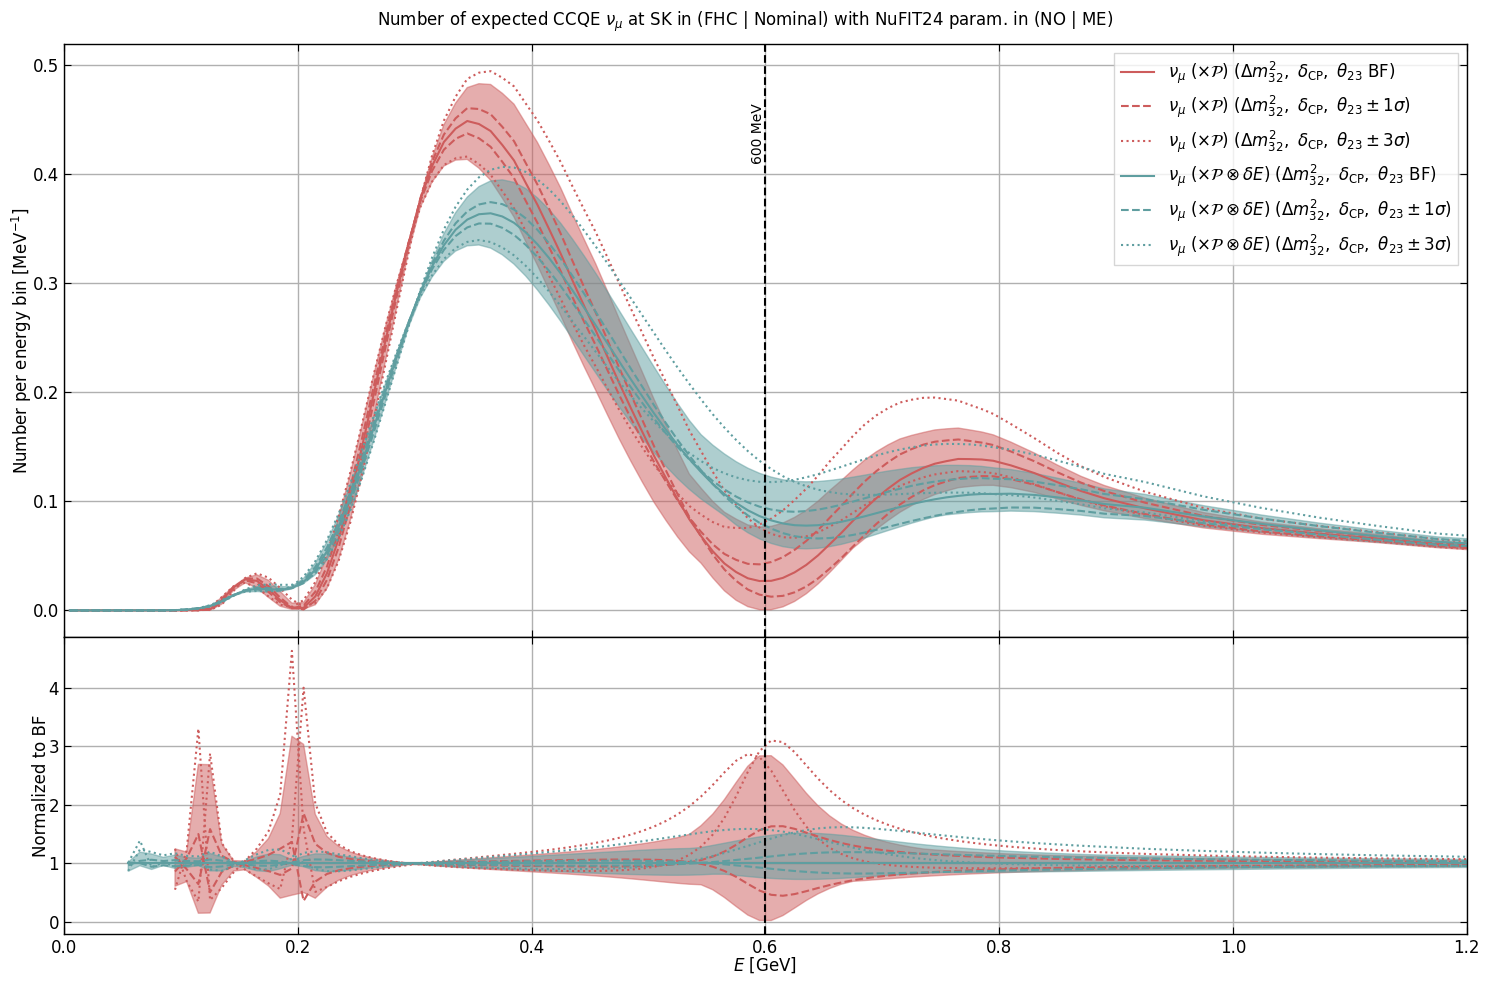

In [25]:
fig, axs = plt.subplots(
    2,
    1,
    sharex="col",
    sharey="row",
    figsize=(15, 10),
    gridspec_kw={"height_ratios": [2, 1]},
)
fig.subplots_adjust(wspace=0, hspace=0)

for key in ["numu"]:
    axs[0].plot(
        (number_oscillated["bf"].minE + number_oscillated["bf"].maxE) / 2,
        number_oscillated["bf"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P}$) ($\Delta m_{32}^2,\ \delta_\text{CP},\ \theta_{23}$ BF)",
        color="indianred",
    )

    axs[0].plot(
        (number_oscillated["p1sigma"].minE + number_oscillated["p1sigma"].maxE) / 2,
        number_oscillated["p1sigma"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P}$) ($\Delta m_{32}^2,\ \delta_\text{CP},\ \theta_{23} \pm 1\sigma$)",
        color="indianred",
        linestyle="--",
    )

    axs[0].plot(
        (number_oscillated["m1sigma"].minE + number_oscillated["m1sigma"].maxE) / 2,
        number_oscillated["m1sigma"][key],
        color="indianred",
        linestyle="--",
    )

    axs[0].plot(
        (number_oscillated["p3sigma"].minE + number_oscillated["p3sigma"].maxE) / 2,
        number_oscillated["p3sigma"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P}$) ($\Delta m_{32}^2,\ \delta_\text{CP},\ \theta_{23} \pm 3\sigma$)",
        color="indianred",
        linestyle="dotted",
    )

    axs[0].plot(
        (number_oscillated["m3sigma"].minE + number_oscillated["m3sigma"].maxE) / 2,
        number_oscillated["m3sigma"][key],
        color="indianred",
        linestyle="dotted",
    )

    axs[0].fill_between(
        (oscillate_max.minE + oscillate_min.maxE) / 2,
        oscillate_max[key],
        oscillate_min[key],
        # label=conv.print_dict[key] + r" ($\times \mathcal{P})\ (\Delta m_{32}^2 \pm 3\sigma$)",
        color="indianred",
        alpha=0.5,
    )

    axs[0].plot(
        (oscillated_smeared["bf"].minE + oscillated_smeared["bf"].maxE) / 2,
        oscillated_smeared["bf"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P} \otimes \delta E$) ($\Delta m_{32}^2,\ \delta_\text{CP},\ \theta_{23}$ BF)",
        color="cadetblue",
    )

    axs[0].plot(
        (oscillated_smeared["p1sigma"].minE + oscillated_smeared["p1sigma"].maxE) / 2,
        oscillated_smeared["p1sigma"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P} \otimes \delta E$) ($\Delta m_{32}^2,\ \delta_\text{CP},\ \theta_{23} \pm 1\sigma$)",
        color="cadetblue",
        linestyle="--",
    )

    axs[0].plot(
        (oscillated_smeared["m1sigma"].minE + oscillated_smeared["m1sigma"].maxE) / 2,
        oscillated_smeared["m1sigma"][key],
        color="cadetblue",
        linestyle="--",
    )

    axs[0].plot(
        (oscillated_smeared["p3sigma"].minE + oscillated_smeared["p3sigma"].maxE) / 2,
        oscillated_smeared["p3sigma"][key],
        label=conv.print_dict[key]
        + r" ($\times \mathcal{P} \otimes \delta E$) ($\Delta m_{32}^2,\ \delta_\text{CP},\ \theta_{23} \pm 3\sigma$)",
        color="cadetblue",
        linestyle="dotted",
    )

    axs[0].plot(
        (oscillated_smeared["m3sigma"].minE + oscillated_smeared["m3sigma"].maxE) / 2,
        oscillated_smeared["m3sigma"][key],
        color="cadetblue",
        linestyle="dotted",
    )

    axs[0].fill_between(
        (smeared_max.minE + smeared_min.maxE) / 2,
        smeared_max[key],
        smeared_min[key],
        # label=conv.print_dict[key] + r" ($\times \mathcal{P})\ (\Delta m_{32}^2 \pm 3\sigma$)",
        color="cadetblue",
        alpha=0.5,
    )

    axs[1].plot(
        (number_oscillated["bf"].minE + number_oscillated["bf"].maxE) / 2,
        number_oscillated["bf"][key] / number_oscillated["bf"][key],
        color="indianred",
    )

    axs[1].plot(
        (number_oscillated["p1sigma"].minE + number_oscillated["p1sigma"].maxE) / 2,
        number_oscillated["p1sigma"][key] / number_oscillated["bf"][key],
        color="indianred",
        linestyle="--",
    )

    axs[1].plot(
        (number_oscillated["m1sigma"].minE + number_oscillated["m1sigma"].maxE) / 2,
        number_oscillated["m1sigma"][key] / number_oscillated["bf"][key],
        color="indianred",
        linestyle="--",
    )

    axs[1].plot(
        (number_oscillated["p3sigma"].minE + number_oscillated["p3sigma"].maxE) / 2,
        number_oscillated["p3sigma"][key] / number_oscillated["bf"][key],
        color="indianred",
        linestyle="dotted",
    )

    axs[1].plot(
        (number_oscillated["m3sigma"].minE + number_oscillated["m3sigma"].maxE) / 2,
        number_oscillated["m3sigma"][key] / number_oscillated["bf"][key],
        color="indianred",
        linestyle="dotted",
    )

    axs[1].fill_between(
        (oscillate_max.minE + oscillate_min.maxE) / 2,
        oscillate_max[key] / number_oscillated["bf"][key],
        oscillate_min[key] / number_oscillated["bf"][key],
        color="indianred",
        alpha=0.5,
    )

    axs[1].plot(
        (oscillated_smeared["bf"].minE + oscillated_smeared["bf"].maxE) / 2,
        oscillated_smeared["bf"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
    )

    axs[1].plot(
        (oscillated_smeared["p1sigma"].minE + oscillated_smeared["p1sigma"].maxE) / 2,
        oscillated_smeared["p1sigma"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        linestyle="--",
    )

    axs[1].plot(
        (oscillated_smeared["m1sigma"].minE + oscillated_smeared["m1sigma"].maxE) / 2,
        oscillated_smeared["m1sigma"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        linestyle="--",
    )

    axs[1].plot(
        (oscillated_smeared["p3sigma"].minE + oscillated_smeared["p3sigma"].maxE) / 2,
        oscillated_smeared["p3sigma"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        linestyle="dotted",
    )

    axs[1].plot(
        (oscillated_smeared["m3sigma"].minE + oscillated_smeared["m3sigma"].maxE) / 2,
        oscillated_smeared["m3sigma"][key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        linestyle="dotted",
    )

    axs[1].fill_between(
        (smeared_max.minE + smeared_min.maxE) / 2,
        smeared_max[key] / oscillated_smeared["bf"][key],
        smeared_min[key] / oscillated_smeared["bf"][key],
        color="cadetblue",
        alpha=0.5,
    )

for ax in axs:
    ax.axvline(x=0.6, linestyle="--", color="black")
axs[0].text(
    x=0.6,
    y=0.9,
    s=r"600 MeV",
    ha="right",
    va="top",
    rotation=90,
    transform=axs[0].get_xaxis_transform(),
)

# plt.xscale("log")
# plt.yscale("log")
axs[1].set_xlabel(r"$E$ [GeV]")
axs[0].set_ylabel(r"Number per energy bin [$\text{MeV}^{-1}$]")
axs[1].set_ylabel(r"Normalized to BF")
# plt.ylim(bottom=1e-1)
axs[0].set_xlim([0.0, 1.2])
# axs[1].set_ylim([0.9,1.12])
# plt.ylim([0.02,0.1])
plt.suptitle(
    r"Number of expected CCQE $\nu_\mu$ at SK in (FHC | Nominal) with NuFIT24 param. in (NO | ME)"
)
axs[0].legend()


plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()